# 浅谈水文中的Bayesian与MCMC

在水文不确定性分析中，一个十分常见的统计理论就是贝叶斯理论，而实际计算中又常常见到MCMC，这里就来看看这些概念的来龙去脉，好好了解下水文水资源中究竟在用这些东西干什么。本文主要参考了以下资料：

- [用模型不确定性理解模型](https://zhuanlan.zhihu.com/p/43873206)
- [The Value of Regionalised Information for Hydrological Modelling](http://hdl.handle.net/10044/1/28086)
- [MCMC随机采样](https://zhuanlan.zhihu.com/p/30003899)
- [机器学习(一) —— 浅谈贝叶斯和MCMC](https://www.xuyankun.cn/2017/05/13/bayes/)
- [贝叶斯学派与频率学派有何不同？](https://www.zhihu.com/question/20587681)
- [贝叶斯定理，使概率论直觉化](https://www.bilibili.com/video/av84799361)
- [贝叶斯估计、最大似然估计、最大后验概率估计](http://noahsnail.com/2018/05/17/2018-05-17-%E8%B4%9D%E5%8F%B6%E6%96%AF%E4%BC%B0%E8%AE%A1%E3%80%81%E6%9C%80%E5%A4%A7%E4%BC%BC%E7%84%B6%E4%BC%B0%E8%AE%A1%E3%80%81%E6%9C%80%E5%A4%A7%E5%90%8E%E9%AA%8C%E6%A6%82%E7%8E%87%E4%BC%B0%E8%AE%A1/)
- [如何理解似然函数?](https://www.zhihu.com/question/54082000)
- [Treatment of input uncertainty in hydrologic modeling: Doing hydrology backward with Markov chain Monte Carlo simulation](https://doi.org/10.1029/2007WR006720)
- [Equifinality of formal (DREAM) and informal (GLUE) Bayesian approaches in hydrologic modeling?](https://doi.org/10.1007/s00477-008-0274-y)
- [概率笔记11——一维正态分布的最大似然估计](https://www.lagou.com/lgeduarticle/2497.html)
- [机器学习-白板推导系列(十三)-MCMC（Markov Chain Monte Carlo）](https://www.bilibili.com/video/av32430563?p=1)

## 从问题出发--不确定性

首先来看水文水资源领域我们想用这方法来干什么？

我们平常遇到的很多问题都需要通过建模来解决的，典型的一个水文模型对应的函数可以简单表示为：$y=f(x,\theta)$，我们有输入值$x$，有模型$f$，有对应参数$\theta$，我们就可以求出我们想要预测或者模拟的y。可是现实世界是复杂的，我们的model结果可能存在很大的不确定性，如果我们不能有效的衡量这种不确定性，那么我们拿得到的y去决策，就可能会有很大的风险，所以理解不确定性就可以让我们尽量避免错误。

模型的不确定性有观测的，有模型结构的，有参数本身的，最终表现到结果的不确定性上。所以要把结果看作是一个**随机变量**，比如预测径流y，它就是一个随机变量，是有概率分布的，那么我们如何判断它的分布呢？也就是说如何衡量预测结果的不确定性呢？

通常我们会假设各个误差源之间的协变关系，假设是独立的，然后误差会经过模型计算传递到输出结果上，我们称之为“forward uncertainty”，我们现在要计算它，即“forward uncertainty estimation”。所有不确定性都考虑，问题比较复杂，这里先只**考虑模型参数不确定性**的情况，接下来没有特别说明，都是这种情况，也就是f固定，观测当作真值。

通常的方法是这样的，我们基于特定的模型结构，也就是针对具体的函数f，因为水文水资源很多模型是复杂非线性的，所以很难显式地去推导它的概率演进，因此我们往往会使用抽样的方法来近似计算。典型的步骤如下图所示：

![](TIM截图20200324232828.png)

也就是随机采样生成参数，然后模拟，最后对得到的结果进行统计分析，累计经验频率曲线，这样我们可以得到我们结果的置信区间，这就是基本的思路。这种方式是基于蒙特卡洛的方法，所以接下来先看看什么是monte carlo方法。

## Monte Carlo

蒙特卡洛方法也称蒙特卡洛抽样方法，其基本思想是通过**大量取样来近似**得到想要的答案。

一个经典的试验就是计算圆周率，在一个边上为2的正方形中画一个内切圆，圆的面积就是 π，圆面积比上整体的正方形面积也是 π, 现在在正方形内产生大量随机数，最后我们只需要计算在圆内点的个数比上总体点的个数，便近似得到了圆周率 π 的值。

蒙特卡罗原来是一个赌场的名称，用它作为名字大概是因为蒙特卡罗方法是一种随机模拟的方法，这很像赌博场里面的扔骰子的过程。最早的蒙特卡罗方法都是为了求解一些不太好求解的求和或者积分问题。比如积分：
$$\theta=\int_a^b f(x)dx$$
如果积分比较难求解。当然我们可以通过蒙特卡罗方法来模拟求解近似值。如何模拟呢？假设我们函数图像如下图:

![](v2-5661858e069a8ca7161b7ba57f872704_720w.jpg)

一个简单的近似求解方法是在[a,b]之间随机的采样一个点。比如 $x_0$ ，然后用 $f(x_0)$ 代表在[a,b]区间上所有的 $f(x)$ 的值。那么上面的定积分的近似求解为:
$$(b-a)f(x_0)$$
当然用一个值代表整个区间，太粗糙了，可以在[a,b]区间上采样n个值，用它们的均值来代表区间上所有的$f(x)$值，这样定积分的近似求解为：
$$\frac{b-a}{n}\sum_{i=0}^{n-1}f(x_i)$$
虽然上面的方法可以一定程度上求解出近似的解，但是它隐含了一个假定，即x在[a,b]之间是均匀分布的，而绝大部分情况，x在[a,b]之间不是均匀分布的。如果我们用上面的方法，则模拟求出的结果很可能和真实值相差甚远。

这时候可以用x在[a,b]的概率分布函数p(x)，那么我们的定积分求和可以这样进行：
$$\theta=\int_a^b f(x)dx=\int_a^b \frac{f(x)}{p(x)}p(x)dx \approx \frac 1 n \sum_{i=0}^{n-1}\frac{f(x_i)}{p(x_i)}$$
上式最右边的这个形式就是**蒙特卡罗方法的一般形式**。当然这里是连续函数形式的蒙特卡罗方法，但是在离散时一样成立。

可以看出，上面我们假设x在[a,b]之间是均匀分布的时候， 就是让上式中的$p(x_i)=1/(b-a)$，也就是说，我们最上面的均匀分布也可以作为一般概率分布函数p(x)在均匀分布时候的特例。那么我们现在的问题转到了如何获取符合分布p(x)的x的若干样本上来。

## 概率分布采样

蒙特卡罗方法的关键是得到x的概率分布。如果求出了x的概率分布，我们可以基于概率分布去采样基于这个概率分布的n个x的样本集，带入蒙特卡罗求和的式子即可求解。但是还有一个关键的问题需要解决，即**如何基于概率分布去采样基于这个概率分布的n个x的样本集**。

首先，对于均匀分布uniform(0,1)，是很容易采样的，已有很多现成的程序可以很方便的生成(0,1)之间的伪随机数。对于其他的概率分布，它们的样本可以通过均匀分布的样本转换得到，比如二维正态分布，可以先采样均匀分布得到$(x_1,x_2)$，然后通过公式转换，公式就不打了，可以参考：https://zhuanlan.zhihu.com/p/30003899 1.3节。

其他一些常见的连续分布，比如t分布，F分布，Beta分布，Gamma分布等，都可以通过类似的方式从uniform(0,1)得到的采样样本转化得到。在python的numpy，scikit-learn等类库中，都有生成这些常用分布样本的函数可以使用。

给个正态分布抽样的简单例子：

(array([ 1.,  4.,  4.,  4.,  6., 10., 14., 27., 29., 39., 44., 63., 62.,
        88., 67., 86., 70., 83., 56., 54., 50., 36., 28., 22., 16., 13.,
         9.,  8.,  4.,  3.]),
 array([72.81542778, 73.5894942 , 74.36356063, 75.13762705, 75.91169347,
        76.68575989, 77.45982632, 78.23389274, 79.00795916, 79.78202558,
        80.55609201, 81.33015843, 82.10422485, 82.87829127, 83.6523577 ,
        84.42642412, 85.20049054, 85.97455696, 86.74862339, 87.52268981,
        88.29675623, 89.07082265, 89.84488908, 90.6189555 , 91.39302192,
        92.16708834, 92.94115477, 93.71522119, 94.48928761, 95.26335403,
        96.03742046]),
 <a list of 30 Patch objects>)

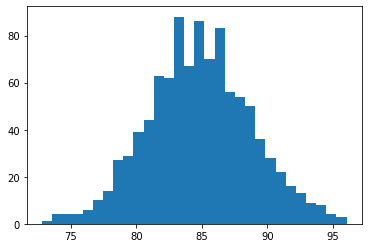

In [2]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt

sampleNo = 1000;
mu = 85
sigma = 4
np.random.seed(0)
s = np.random.normal(mu, sigma, sampleNo )
plt.hist(s, 30)

对于概率分布不是常见的分布，一个可行的办法是采用**接受-拒绝采样**来得到该分布的样本。既然 p(x) 太复杂在程序中没法直接采样，那么我设定一个程序可采样的分布 q(x) 比如高斯分布，然后按照一定的方法拒绝某些样本，以达到接近 p(x) 分布的目的，其中q(x)叫做 proposal distribution。

具体采用过程如下，设定一个方便采样的常用概率分布函数 q(x)，以及一个常量 k，使得 p(x) 总在 kq(x) 的下方，如下图所示。

![](v2-e0f2987387b28ab89f8b2065a285a7e4_720w.jpg)

首先，采样得到q(x)的一个样本$x_0$，然后从均匀分布(0,kq(z_0))中采样得到要给值u，如果u落在了途中的灰色区域，则拒绝这次抽样，否则就接受这个样本。重复以上过程得到n个接受的样本$z_0,z_1,\cdots,z_{n-1}$，则蒙特卡洛方法求解结果为：
$$\frac 1 n \sum_{i=0}^{n-1}\frac{f(z_i)}{p(z_i)}$$

以上就是一些基本的抽样方法，先到这里，接下来先回到问题上来。

## 继续看问题--贝叶斯视角

回到径流预报模型函数f上来。我们建模的时候不仅仅是想量化不确定性，还想要不断地利用新的信息来减小不确定性，这就是贝叶斯学派的世界观了。而相对应的，前面提到的抽样获取不确定性的思路就有些频率学派的意思。关于贝叶斯统计的基本思维方式可以参考：https://www.zhihu.com/question/20587681

在贝叶斯视角下，最基本的公式就是贝叶斯公式了。所以我们简单补充下贝叶斯公式相关的基本概念。

## 贝叶斯公式

贝叶斯公式是本科学过的内容，其基本原理可以参考：https://www.bilibili.com/video/av84799361

这里直接给出公式：
$$\pi(\theta_i|x)=\frac{f(x|\theta_i)\pi(\theta_i)}{\sum_i f(x|\theta_i)\pi(\theta_i)}$$

以上是离散形式下的公式，下面给出连续形式下的：
$$\pi(\theta|x)=\frac{f(x|\theta)\pi(\theta)}{\int_{\Theta} f(x|\theta)\pi(\theta)d\theta}$$

$\pi$是参数的概率分布，$\pi(\theta)$是先验概率，$\pi(\theta|x)$是后验分布，f(x|\theta)是似然函数。积分区间$\Theta$是参数$\theta$所有可能取到的值的域。所以后验概率就是在植到x的前提下，在$\Theta$域内的一个关于$\theta$的概率密度分布，每一个$\theta$都有一个对应的可能性。

现在说下理解，首先似然函数，似然函数是指观测到的样本x的分布是以某个参数$\theta$为前提下得出的。但是参数不知道是多少，所以才会有参数估计，比如本科学的极大似然估计。就是字面意思，把似然算的最大，公式是这样的：
$$lik(\theta)=\prod_{i=1}^nf(x_i|\theta)$$
找到让它最大的$\theta$就是极大似然估计。

关于似然和概率的区别，可以参考：https://www.zhihu.com/question/54082000

接着看看后验概率，后验概率是一系列参数的概率分布，即我们得到了许多个参数及其对应的可能性，我们只需从中选取想要的值即可，比如想要概率最大的那个参数，就是后验众数估计，想要参数分布的中位数，就是后验中位数估计，想要参数分布的均值，就是后验期望估计。这几种没有好坏，只是提供了几种得出参数的方法。

另外，区分下置信区间和可信区间的概念，或者说概率的置信区间和参数的置信区间的概念。置信区间是指参数取一组值时候的概念，比如正态分布某个均值和方差条件下的，95%置信区间表示了一个具体的区间范围。而可信区间是针对后验分布中的参数$\theta$而言的，通过后验分布计算，我们得到了很多参数值，取其中对应概率更大一些的，比如大于95%，这些参数的构成的区间是可信区间。

然后再说说先验分布，最后说是因为先验分布是个对参数概率分布的**主观判断**！如何不知道任何信息，那么取均匀分布即可，即认为所有可能一样，这时候就是无信息先验，因为本文主要目的是了解水文中bayes和MCMC的一些基本应用逻辑，所以下面关于先验的内容，就先考虑无信息先验的情况，这样会简单一些。

上面给出的后验计算公式中，当$\theta$只有一个值时，后验分布分母的那个积分还是可以算的，可以当$\theta$很多时，那是根本没法算的，并且很多时候即便是一个参数，积分可能都是很难算的。所以就有了通过近似来获取答案的方法--即前面提到的蒙特卡洛方法。

现在看回贝叶斯公式，先假设我们已经有了后验概率$\pi (\theta|x)$，如果想要知道的时关于$\theta$的函数$f(\theta)$的（后验）期望，则根据期望公式有:
$$E[f(\theta)|x]=\int f(\theta)\pi(\theta|x)d\theta$$
当$f(\theta)=\theta$时，就是前面说的后验期望估计，当$f(\theta)$是其他情况时，会得到其他我们想要的结果，比如我们的模型计算。蒙特卡洛方法指出：如果我们可以从**后验概率分布 $\pi (\theta|x)$ 中抽取**大量的独立同分布(i.i.d)的观测值 $\theta_1,\theta_2,\cdots,\theta_m$时 ,于是我们可以用如下公式作为$E[f(\theta)|x]$的近似值（大数定律）
$$f_m=\frac 1 m \sum_{i=1}^m f(\theta _i)$$
所以关键也就是如何抽样了，这就是前面提到的抽样在贝叶斯框架下的作用。

## 问题再看-模型参数率定

在具体到MCMC之前，先进一步思考我们的问题。考虑参数不确定性的情况，一开始的时候我们对参数有一个先验分布的认识，然后在贝叶斯框架下，我们可以根据观测值（似然）来提升我们对模型参数的认识，量化模型参数的概率分布（后验概率）。也就是说，我们有观测值可以帮助我们更好地了解参数，这其实就是水文模型参数率定地知识范围。一个典型地参数率定过程如下图所示。

![](TIM截图20200325175743.png)

最上面一行图是上帝视角，不可知的真实的水文响应。通过观测我们可以获取到输入，f是水文模型，经过模型我们可以模拟出响应值，然后和观测的响应值比较，通过比较结果来优化模型的参数，优化前我们对参数有一些了解，比如大致的取值范围等。

因为获取参数的过程是从观测到模型参数，而不是计算的时候从参数到响应，所以通常会将这一过程称为inverse problem（水文中inverse也有不同的涵义，这里就是指求参）。

以上数学表达可以这么写：

公式$y=f(\theta,\widetilde {x})$表示根据观测的forcing data $\widetilde {x}$和模型$f$及其参数$\theta$，可以计算得到模拟的径流值${y}$。

令$\widetilde {y}=\{\widetilde{y_1},\cdots,\widetilde{y_n}\}$表示n个观测值对应的向量。则有残差向量：$E(\theta)=\{y-\widetilde {y}\}=\{{y_1}-\widetilde{y_1},\cdots,{y_n}-\widetilde{y_n}\}=\{e_1(\theta),\cdots,e_n(\theta)\}$

通常我们要找的是令预测和观测差别最小的参数。可以通过最小化simple least squares(SLS)公式$F_{SLS}(\theta)=\sum_{i=1}^n e_i(\theta)^2$来实现。

按照前面第一次分析问题时的情况，只考虑参数不确定性，可以简单通过mc即可分析，事实上一般的参数率定就是只考虑参数不确定性的情况，而实际中至少观测也是有不确定性的，这时候我们就要通过贝叶斯框架量化不确定性，给出概率分布，这也是贝叶斯框架的另一个优势，不只是一种新视角，还能考虑多种不确定性，本文从现在开始考虑观测的不确定性，以下不明确说明都是指这种情况。所以重新看待inverse problem。

首先，考虑某个模型f预测的贝叶斯公式：
$$p(\theta|\widetilde {y},\widetilde {x})=\frac{p(\theta)p(\widetilde {y},\widetilde {x}|\theta)}{p(\widetilde {y},\widetilde {x})}$$

为了方便，我们先把$\widetilde {y},\widetilde {x}$统一到$\widehat{y}$，$\widehat y \in \widehat{\textbf Y}$，$\widehat{\textbf Y}$ 是样本空间。$\theta \in \Theta$，$\Theta$是参数空间。$\widehat{\textbf Y}$和${\Theta}$都有概率分布。$p(\theta)$是参数$\theta$先验分布，描述观测数据之前对参数的了解。$p(\widehat y|\theta)$是给定参数条件下的观测样本分布，我们可以求参数的后验分布。分母$p(\widehat y)$是$\widehat y$和$\theta$的联合分布的边缘分布，所以有：
$$p(\widehat y)=\int _{\Theta} p(\widehat y|\theta)p(\theta)d\theta$$
分母是一个值，主要是起到一个scaling的作用，保证后验是小于1的，是一个有效的概率分布。所以通常会将贝叶斯公式表示为：
$$p(\theta|\widehat y)=cp(\widehat y|\theta)p(\theta)$$

现在重点是似然函数，思考这里的逻辑。结合前面似然和概率的概念区别的补充资料，$p(\widehat y|\theta)=l(\theta|\widehat y)$

我们一般意义下的率定参数本来就是给定$\widehat y$下的$\theta$，而似然就是干这个事的，只不过是从概率上考虑，为了能让公式有显式的数学表达，一般会假设残差是符合正态分布的，先假设各个时段的残差是独立同分布的正态分布，那么似然函数就是
$$\prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_e^2}} exp(-\frac{(x_e-\mu _e)^2}{2\sigma_e^2})$$
这部分计算可以参考：https://www.lagou.com/lgeduarticle/2497.html

假如可以显式地写出后验概率分布，也就是参数的后验分布有明确的解析式，那么inverse问题就结束了，即参数就知道了，可以选择概率最大的参数，就是后验最大估计。

然而实际上，显式计算是困难的，接下来分析。注意，接下来就是最关键的部分了。

## 继续问题--为什么需要MCMC

